# Packages

In [ ]:
# Global packages
import numpy as np
from PIL import Image
%matplotlib inline

import matplotlib.pyplot as plt

# Combining Masked Images
import os
import shutil

# 3CH Images
import cv2

# loading images
import random
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# hyperparameter
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Combining the Masked Images

In [ ]:
def combine_masks(folder_path):
    mask_files = [file for file in os.listdir(folder_path) if 'mask' in file]
    mask_groups = {}

    for mask_file in mask_files:
        group_name = mask_file.split('_')[0]  # Extract group name (e.g., "benign (4)")
        if group_name not in mask_groups:
            mask_groups[group_name] = []

        mask_groups[group_name].append(mask_file)

    for group_name, group_files in mask_groups.items():
        combined_mask = None
        for file in group_files:
            mask_image = cv2.imread(os.path.join(folder_path, file))
            if combined_mask is None:
                combined_mask = mask_image
            else:
                combined_mask = cv2.bitwise_or(mask_image, combined_mask)

        if len(group_files) > 1:
            for file in group_files:
                file_path = os.path.join(folder_path, file)
                new_folder = './Dataset_BUSI/Dataset_BUSI_with_GT/all_extra_masks'  # Specify the path to the new folder
                new_file_path = os.path.join(new_folder, file)
                shutil.move(file_path, new_file_path)
            cv2.imwrite(f'./Dataset_BUSI/Dataset_BUSI_with_GT/benign/{group_name}_mask.png', combined_mask)

# Replace 'folder_path' with the path to your folder containing mask images
folder_path = './Dataset_BUSI/Dataset_BUSI_with_GT/benign/'
combine_masks(folder_path)

# Using BUSI Images
- Normal: 133
- Benign: 437
- Malignant: 210

# Creating Segmented Images
<p> Remember that we have to create segmented images of EVERY SINGLE malignant, benign, and normal cancer images from the original ultrasound image and the masked image.

In [ ]:
def display_fused_image(original_image_path, mask_image_path):
  '''
  Args:
    original_image_path: The path to the original image file
    tumor_shape_path: The path to the masked image file

  Returns:
    A path to the segmented image after saving the image
  '''

  original_image = Image.open(original_image_path)
  mask_image = Image.open(mask_image_path).convert("L")

  # Create a new image with transparency (RGBA mode)
  segmented_image = Image.new("RGBA", original_image.size, (0, 0, 0, 255))

  # Create a mask from the tumor shape image
  tumor_mask = np.array(mask_image)

  #print("Original Image Size:", original_image.size)
  #print("Mask Image Size:", mask_image.size)
  #print("Mask Image Data Type:", tumor_mask.dtype)

  # Paste the tumor shape image with transparency onto the new image
  segmented_image.paste(original_image, (0, 0), mask=Image.fromarray(tumor_mask))

  # Save the image
  segmented_image_path = f'{os.path.splitext(original_image_path)[0]}_fused.png'
  segmented_image.save(segmented_image_path)

  return segmented_image_path

def get_all_image_into_paths(folder_path):
  """
  Args:
    folder_path: The path to the folder that contains the images.

  Returns:
    A list of the paths to the original and masked images
  """
  original_image_paths = []
  mask_image_paths = []

  for file_name in os.listdir(folder_path):
    if file_name.endswith("_mask.png"):
      mask_image_paths.append(os.path.join(folder_path, file_name))
    elif file_name.endswith(").png"):
      original_image_paths.append(os.path.join(folder_path, file_name))
    else:
      continue
  return mask_image_paths, original_image_paths

folder_path = "./Dataset_BUSI/Dataset_BUSI_with_GT/benign/"
mask_image_paths, original_image_paths = get_all_image_into_paths(folder_path)

segmented_image_paths = []

for i in range(len(original_image_paths)):
  print(i)
  print(mask_image_paths[i])
  print(original_image_paths[i])
  segmented_image_paths.append(display_fused_image(original_image_paths[i], mask_image_paths[i]))

0
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (1)_mask.png
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (1).png
Original Image Size: (562, 471)
Mask Image Size: (562, 471)
Mask Image Data Type: uint8
1
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (10)_mask.png
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (10).png
Original Image Size: (683, 585)
Mask Image Size: (683, 585)
Mask Image Data Type: uint8
2
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (100)_mask.png
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (100).png
Original Image Size: (323, 473)
Mask Image Size: (323, 473)
Mask Image Data Type: uint8
3
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (101)_mask.png
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (101).png
Original Image Size: (563, 473)
Mask Image Size: (563, 473)
Mask Image Data Type: uint8
4
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (102)_mask.png
./Dataset_BUSI/Dataset_BUSI_with_GT/benign/benign (102).png
Original Image Size

# Creating 3-channel Images (Malignant, Benign, Normal)
<p>Also, we then have to create the 3-channel image (RGB) to feed it into our fine-tuning process. We need to create a 3 channel image because in the end we want to fine-tune a pre-trained model.
Since most pre-trained models are based on colored images, the have 3 channels. So, most pre-trained models will expect to have a 3 channel image as their input EVEN when we are fine-tuning it. If we feed a grayscale image to a pre-trained model, it will not be able to learn as effectively.</p>

[Read this paper for more info](https://www.sciencedirect.com/science/article/pii/S0169260719307059?via%3Dihub#:~:text=Fig.%206.%20Image,that%20produces%20from%20(b))</p>

In [ ]:
def create_combined_image(folder_path, original_image_path, mask_image_path, segmented_image_path):
    # Load the three images (original image, segmented image, masked image)
    original_tumor = cv2.imread(original_image_path)
    segmented_tumor = cv2.imread(segmented_image_path)
    tsi = cv2.imread(mask_image_path)

    # Create an empty image with three channels
    height, width, _ = original_tumor.shape
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Place the images into specific channels
    combined_image[:, :, 0] = tsi[:, :, 0]  # Red channel from TSI (tumor-specific area)
    combined_image[:, :, 1] = segmented_tumor[:, :, 1]  # Green channel from segmented tumor
    combined_image[:, :, 2] = original_tumor[:, :, 2]  # Blue channel from original tumor

    output_path = os.path.join(folder_path, "train", f"{os.path.splitext(os.path.basename(original_image_path))[0]}_rgb.png")
    cv2.imwrite(output_path, combined_image)

folder_path = "./Dataset_BUSI/Dataset_BUSI_with_GT/"

for i in range(len(original_image_paths)):
    create_combined_image(folder_path, original_image_paths[i], mask_image_paths[i], segmented_image_paths[i])

# Loading Dataset

In [ ]:
data_path = "./Dataset_BUSI/Dataset_BUSI_with_GT/train/"

transform_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # here do not use transforms.Normalize(mean, std)
])

image_data = datasets.ImageFolder(
  root=data_path, transform=transform_img
)

image_data_loader = DataLoader(
  image_data,
  batch_size=len(image_data),
  shuffle=False,
  num_workers=0
)

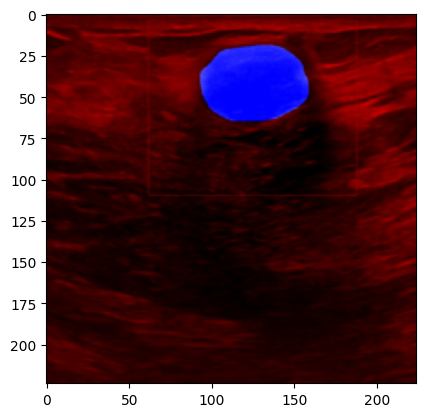

In [ ]:
# Python code to visualize an image
images, labels = next(iter(image_data_loader))

def display_image(images):
  images_np = images.numpy()
  img_plt = images_np.transpose(0,2,3,1)
  # display 5th image from dataset
  plt.imshow(img_plt[4])

display_image(images)

In [ ]:
images.mean([0, 2, 3])

tensor([0.3301, 0.0230, 0.0943])

# Calculate Mean and STD

In [ ]:
# python code calculate mean and std
image_data_loader = DataLoader(
    image_data,
    # batch size is whole dataset
    batch_size=len(image_data),
    shuffle=False,
    num_workers=0
)
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.3301, 0.0230, 0.0943]) tensor([0.2206, 0.0886, 0.2902])


In [ ]:
# python code to calculate mean and std
batch_size = 2

loader = DataLoader(
  image_data,
  batch_size = batch_size,
  num_workers=1)

def batch_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)
    return mean,std

mean, std = batch_mean_and_sd(loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.3322, 0.0275, 0.1132]) tensor([0.2215, 0.0965, 0.3152])


In [ ]:
# python code to normalize the image
data_path = data_path = "./Dataset_BUSI/Dataset_BUSI_with_GT/train/"

transform_img_normal = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_data_normal = torchvision.datasets.ImageFolder(
  root=data_path,
  transform=transform_img_normal
)

image_data_loader_normal = DataLoader(
  image_data_normal,
  batch_size=len(image_data),
  shuffle=False,
  num_workers=0
)

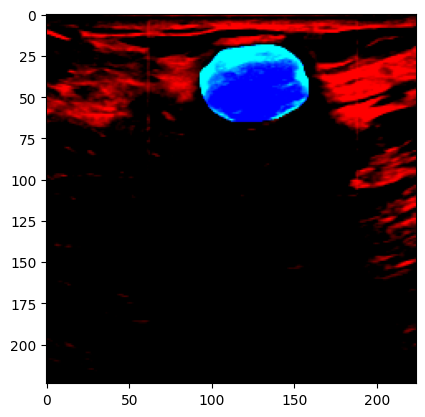

In [ ]:
images_normal, labels = next(iter(image_data_loader_normal))
display_image(images_normal)

In [ ]:
mean_normal, std_normal = mean_std(image_data_loader_normal)
print("mean and std after normalize:\n",
      mean_normal, std_normal)

mean and std after normalize:
 tensor([-4.5483e-07,  1.8154e-08, -2.0522e-07]) tensor([1., 1., 1.])
